In [ ]:
# 0.5 mW optical power
# selected location away from NV 'line' in confocal scan
# 5e5 counts / sec. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import optimize
import copy
from scipy.optimize import leastsq
import scipy 

import logging


In [4]:
from qt3utils.pulsers.pulseblaster import PulseBlasterT1

In [5]:
import qt3utils.experiments.t1coherence
import qt3utils.nidaq
import qt3utils.experiments.common

In [15]:
pulser = PulseBlasterT1(aom_channels = [0,16], clock_channels = [2,18], 
                trigger_channels = [3,19], trigger_pulse_duration=5e-6,
                clock_period=.25e-6, aom_pulse_duration_time = 10e-6,
                pb_board_number = 0)
pulser.set_full_cycle_length(.5e-3)
print(pulser.program_pulser_state(20e-6))
pulser.start()

2000


In [7]:
pulser.experimental_conditions()

{'full_cycle_width': 0.001,
 'clock_channels': [2, 18],
 'clock_period': 5e-07,
 'channel_settings': [{'channel': 3, 'start': 0, 'width': 5e-06},
  {'channel': 19, 'start': 0, 'width': 5e-06},
  {'channel': 0, 'start': 0, 'width': 1e-05},
  {'channel': 16, 'start': 0, 'width': 1e-05},
  {'channel': 0, 'start': 0.00047, 'width': 1e-05},
  {'channel': 16, 'start': 0.00047, 'width': 1e-05},
  {'channel': 0, 'start': 0.0005, 'width': 1e-05},
  {'channel': 16, 'start': 0.0005, 'width': 1e-05}]}

In [8]:
logging.basicConfig(level=logging.WARNING)
qt3utils.experiments.t1coherence.logger.setLevel(logging.DEBUG)

In [9]:
def plot_trace(trace, N_cycles=1, clock_rate=1, label = None):
    plt.plot(np.arange(len(trace)) / clock_rate, trace * clock_rate / N_cycles, label = label)
    
def get_nearest_scan_independent_var(scan_data, var):
    scan_values = np.array([x[0] for x  in scan_data ])
    idx = (np.abs(scan_values - var)).argmin()
    return idx, scan_values[idx]

def plot_nearest_scan_independent_var(scan_data,  experiment, var):
    idx, nearest_var = get_nearest_frequency(scan_data, var)
    scan = scan_data[idx]
    plot_trace(scan[1], experiment.N_cycles, clock_rate = 1./experiment.pulser.clock_period, label = scan[0])
    return nearest_var

In [16]:
nidaq_config = qt3utils.nidaq.EdgeCounter('Dev1')

In [39]:
experiment = qt3utils.experiments.t1coherence.T1Coherence(pulser, nidaq_config, 
                                                          tau_delay_high=200e-6, 
                                                          tau_delay_step=50e-6, 
                                                          tau_delay_low=50e-6)

In [18]:
t1_scan_agg = experiment.run(N_cycles=2000, post_process_function=qt3utils.experiments.common.aggregate_sum)

INFO:qt3utils.experiments.t1coherence:tau 5.00e-05
DEBUG:qt3utils.experiments.t1coherence:Acquiring 4000000 samples
DEBUG:qt3utils.experiments.t1coherence:   Sample period of 2.5e-07 seconds
DEBUG:qt3utils.experiments.t1coherence:   acquisition time of 1.0 seconds
INFO:qt3utils.experiments.t1coherence:tau 1.00e-04
DEBUG:qt3utils.experiments.t1coherence:Acquiring 4000000 samples
DEBUG:qt3utils.experiments.t1coherence:   Sample period of 2.5e-07 seconds
DEBUG:qt3utils.experiments.t1coherence:   acquisition time of 1.0 seconds
INFO:qt3utils.experiments.t1coherence:tau 1.50e-04
DEBUG:qt3utils.experiments.t1coherence:Acquiring 4000000 samples
DEBUG:qt3utils.experiments.t1coherence:   Sample period of 2.5e-07 seconds
DEBUG:qt3utils.experiments.t1coherence:   acquisition time of 1.0 seconds
INFO:qt3utils.experiments.t1coherence:tau 2.00e-04
DEBUG:qt3utils.experiments.t1coherence:Acquiring 4000000 samples
DEBUG:qt3utils.experiments.t1coherence:   Sample period of 2.5e-07 seconds
DEBUG:qt3utils

<IPython.core.display.Javascript object>


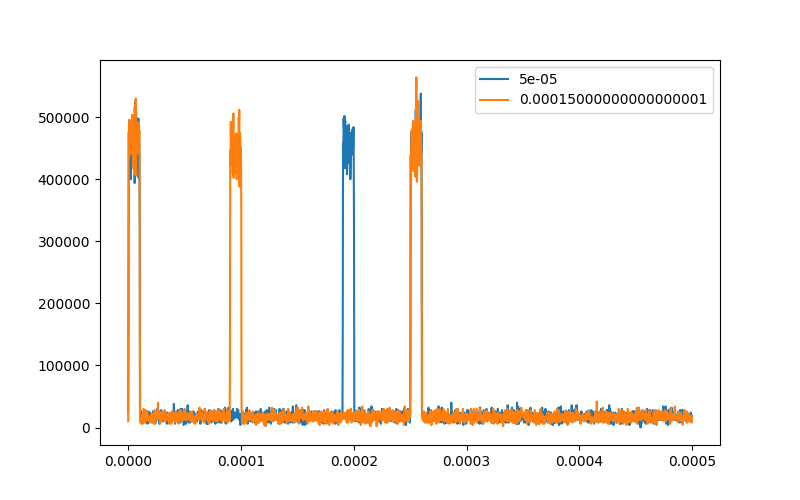

In [19]:
fig, ax = plt.subplots(figsize=(8,5))

for scan in t1_scan_agg[::2]:
    plot_trace(scan[1], experiment.N_cycles, clock_rate = 1./experiment.pulser.clock_period, label = scan[0])
plt.legend()

<IPython.core.display.Javascript object>


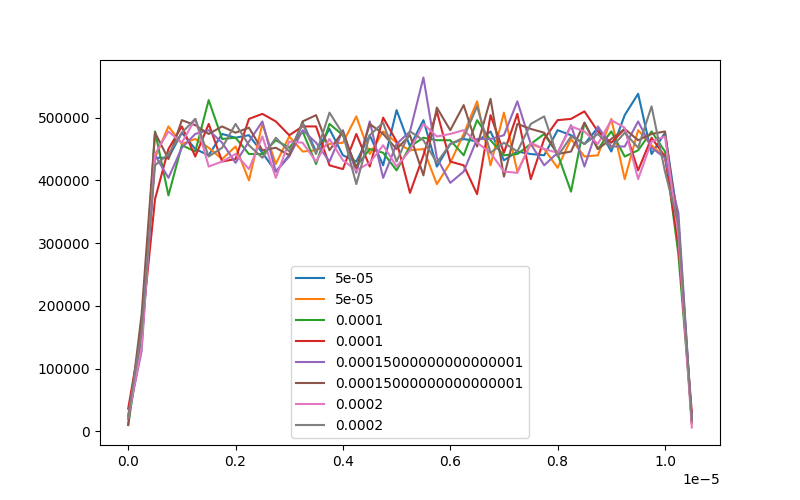

In [21]:
fig, ax = plt.subplots(figsize=(8,5))

for scan in t1_scan_agg[::1]:
    aom_width = int((experiment.pulser.aom_pulse_duration_time + experiment.pulser.aom_response_time) // experiment.pulser.clock_period) 

    start = len(scan[1])//2
    stop = start + aom_width
    #signal
    plot_trace(scan[1][start:stop], experiment.N_cycles, clock_rate = 1./experiment.pulser.clock_period, label = scan[0])
    
    #background 
    start = 0
    stop = start + aom_width
    plot_trace(scan[1][start:stop], experiment.N_cycles, clock_rate = 1./experiment.pulser.clock_period, label = scan[0])
plt.legend()

In [38]:
def contrast_calculator(data_buffer, experiment):
    trace = qt3utils.experiments.common.aggregate_sum(data_buffer, experiment)
    aom_width = int((experiment.pulser.aom_pulse_duration_time + experiment.pulser.aom_response_time) // experiment.pulser.clock_period) 
    aom_width += 2 # we add two clock periods to handle the clock_delay in the experiment
    start_background = 0
    end_background = start_background + aom_width
    background_pl_rate = trace[start_background:end_background]
    
    start_signal = len(trace)//2
    end_signal = start_signal + aom_width
    signal_pl_rate = trace[start_signal:end_signal]
    
    return np.sum(signal_pl_rate)/np.sum(background_pl_rate)


In [46]:
t1_scan_agg = experiment.run(N_cycles=50000, post_process_function=contrast_calculator)

INFO:qt3utils.experiments.t1coherence:tau 1.00e-05
INFO:qt3utils.experiments.t1coherence:tau 2.00e-05
INFO:qt3utils.experiments.t1coherence:tau 3.00e-05
INFO:qt3utils.experiments.t1coherence:tau 4.00e-05
INFO:qt3utils.experiments.t1coherence:tau 5.00e-05
INFO:qt3utils.experiments.t1coherence:tau 6.00e-05
INFO:qt3utils.experiments.t1coherence:tau 7.00e-05
INFO:qt3utils.experiments.t1coherence:tau 8.00e-05
INFO:qt3utils.experiments.t1coherence:tau 9.00e-05
INFO:qt3utils.experiments.t1coherence:tau 1.00e-04
INFO:qt3utils.experiments.t1coherence:tau 1.10e-04
INFO:qt3utils.experiments.t1coherence:tau 1.20e-04
INFO:qt3utils.experiments.t1coherence:tau 1.30e-04
INFO:qt3utils.experiments.t1coherence:tau 1.40e-04
INFO:qt3utils.experiments.t1coherence:tau 1.50e-04
INFO:qt3utils.experiments.t1coherence:tau 1.60e-04
INFO:qt3utils.experiments.t1coherence:tau 1.70e-04
INFO:qt3utils.experiments.t1coherence:tau 1.80e-04
INFO:qt3utils.experiments.t1coherence:tau 1.90e-04
INFO:qt3utils.experiments.t1coh

<IPython.core.display.Javascript object>


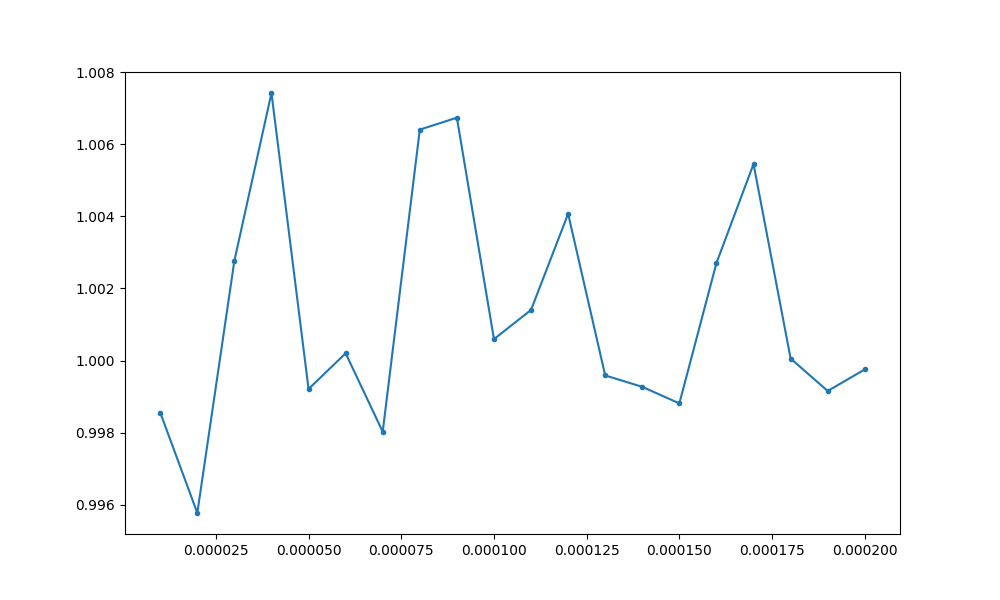

In [47]:
plt.figure(figsize=(10,6))
scan = np.array(t1_scan_agg)
x_data = scan[:, 0]
y_data = scan[:, 1]
plt.plot(x_data, y_data, '.-')

In [40]:
pulser = PulseBlasterT1(aom_channels = [0,16], clock_channels = [2,18], 
                trigger_channels = [3,19], trigger_pulse_duration=2e-6,
                clock_period=2e-6, aom_pulse_duration_time = 50e-6,
                pb_board_number = 0, full_cycle_width=4e-3)

In [41]:
pulser.reset()

In [42]:
pulser.program_pulser_state(200e-6)

2000

In [43]:
pulser.start()

In [44]:
experiment.tau_delay_high=1.75e-3
experiment.tau_delay_step=200e-6
experiment.tau_delay_low=100e-6
experiment.pulser = pulser

In [36]:
t1_scan_agg = experiment.run(N_cycles=500, post_process_function=qt3utils.experiments.common.aggregate_sum)

INFO:qt3utils.experiments.t1coherence:tau 1.00e-04
DEBUG:qt3utils.experiments.t1coherence:Acquiring 1000000 samples
DEBUG:qt3utils.experiments.t1coherence:   Sample period of 2e-06 seconds
DEBUG:qt3utils.experiments.t1coherence:   acquisition time of 2.0 seconds
INFO:qt3utils.experiments.t1coherence:tau 3.00e-04
DEBUG:qt3utils.experiments.t1coherence:Acquiring 1000000 samples
DEBUG:qt3utils.experiments.t1coherence:   Sample period of 2e-06 seconds
DEBUG:qt3utils.experiments.t1coherence:   acquisition time of 2.0 seconds
INFO:qt3utils.experiments.t1coherence:tau 5.00e-04
DEBUG:qt3utils.experiments.t1coherence:Acquiring 1000000 samples
DEBUG:qt3utils.experiments.t1coherence:   Sample period of 2e-06 seconds
DEBUG:qt3utils.experiments.t1coherence:   acquisition time of 2.0 seconds
INFO:qt3utils.experiments.t1coherence:tau 7.00e-04
DEBUG:qt3utils.experiments.t1coherence:Acquiring 1000000 samples
DEBUG:qt3utils.experiments.t1coherence:   Sample period of 2e-06 seconds
DEBUG:qt3utils.experim

<IPython.core.display.Javascript object>


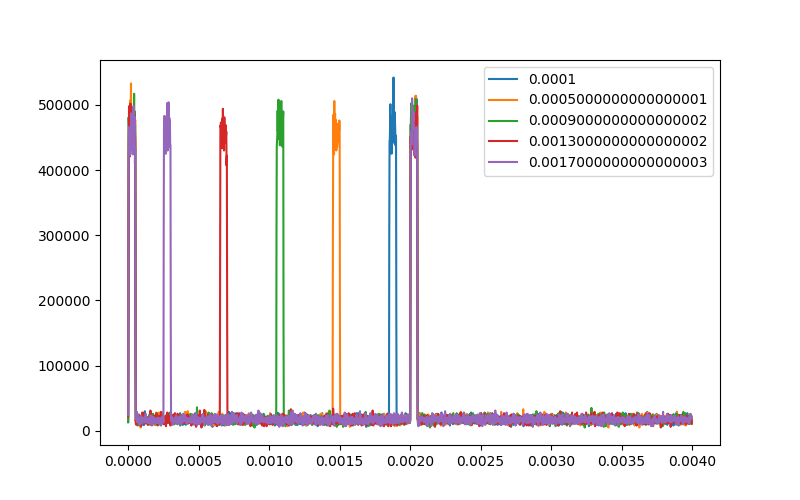

In [37]:
fig, ax = plt.subplots(figsize=(8,5))

for scan in t1_scan_agg[::2]:
    plot_trace(scan[1], experiment.N_cycles, clock_rate = 1./experiment.pulser.clock_period, label = scan[0])
plt.legend()

In [49]:
pulser.aom_pulse_duration_time = 100e-6

In [52]:
def contrast_calculator(data_buffer, experiment):
    trace = qt3utils.experiments.common.aggregate_sum(data_buffer, experiment)
    aom_width = int((experiment.pulser.aom_pulse_duration_time + experiment.pulser.aom_response_time) // experiment.pulser.clock_period)
    aom_width += int(experiment.pulser.clock_delay // experiment.pulser.clock_period)  # we add two clock periods to handle the clock_delay in the experiment
    start_background = 0
    end_background = start_background + aom_width
    background_pl_rate = trace[start_background:end_background]

    start_signal = len(trace) // 2
    end_signal = start_signal + aom_width
    signal_pl_rate = trace[start_signal:end_signal]

    return np.sum(signal_pl_rate) , np.sum(background_pl_rate), trace

In [53]:
t1_scan = experiment.run(N_cycles=5000, post_process_function=contrast_calculator)

INFO:qt3utils.experiments.t1coherence:tau 1.00e-04
DEBUG:qt3utils.experiments.t1coherence:Acquiring 10000000 samples
DEBUG:qt3utils.experiments.t1coherence:   Sample period of 2e-06 seconds
DEBUG:qt3utils.experiments.t1coherence:   acquisition time of 20.0 seconds
INFO:qt3utils.experiments.t1coherence:tau 3.00e-04
DEBUG:qt3utils.experiments.t1coherence:Acquiring 10000000 samples
DEBUG:qt3utils.experiments.t1coherence:   Sample period of 2e-06 seconds
DEBUG:qt3utils.experiments.t1coherence:   acquisition time of 20.0 seconds
INFO:qt3utils.experiments.t1coherence:tau 5.00e-04
DEBUG:qt3utils.experiments.t1coherence:Acquiring 10000000 samples
DEBUG:qt3utils.experiments.t1coherence:   Sample period of 2e-06 seconds
DEBUG:qt3utils.experiments.t1coherence:   acquisition time of 20.0 seconds
INFO:qt3utils.experiments.t1coherence:tau 7.00e-04
DEBUG:qt3utils.experiments.t1coherence:Acquiring 10000000 samples
DEBUG:qt3utils.experiments.t1coherence:   Sample period of 2e-06 seconds
DEBUG:qt3utils.

In [55]:
t1_scan

array([[0.0001,
        (226880.0, 224846.0, array([ 155., 2999., 4472., ...,  147.,  158.,  177.]))],
       [0.00030000000000000003,
        (226875.0, 225890.0, array([ 180., 2891., 4449., ...,  151.,  153.,  178.]))],
       [0.0005000000000000001,
        (226210.0, 225477.0, array([ 140., 2820., 4402., ...,  184.,  179.,  163.]))],
       [0.0007000000000000001,
        (226583.0, 226873.0, array([ 196., 2965., 4320., ...,  158.,  160.,  166.]))],
       [0.0009000000000000002,
        (226053.0, 225877.0, array([ 191., 2854., 4388., ...,  173.,  159.,  155.]))],
       [0.0011000000000000003,
        (225897.0, 224754.0, array([ 169., 2868., 4286., ...,  171.,  192.,  157.]))],
       [0.0013000000000000002,
        (226279.0, 225693.0, array([ 168., 2978., 4423., ...,  177.,  179.,  168.]))],
       [0.0015000000000000002,
        (226437.0, 225947.0, array([ 199., 2985., 4460., ...,  185.,  181.,  173.]))],
       [0.0017000000000000003,
        (227331.0, 226950.0, array([ 18

<IPython.core.display.Javascript object>


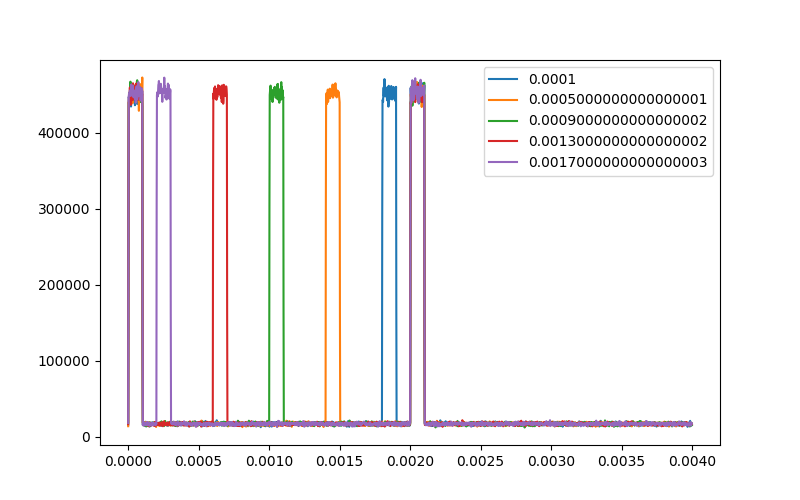

In [56]:
# raw trace
fig, ax = plt.subplots(figsize=(8,5))

for scan in t1_scan[::2]:
    plot_trace(scan[1][2], experiment.N_cycles, clock_rate = 1./experiment.pulser.clock_period, label = scan[0])
plt.legend()

<IPython.core.display.Javascript object>


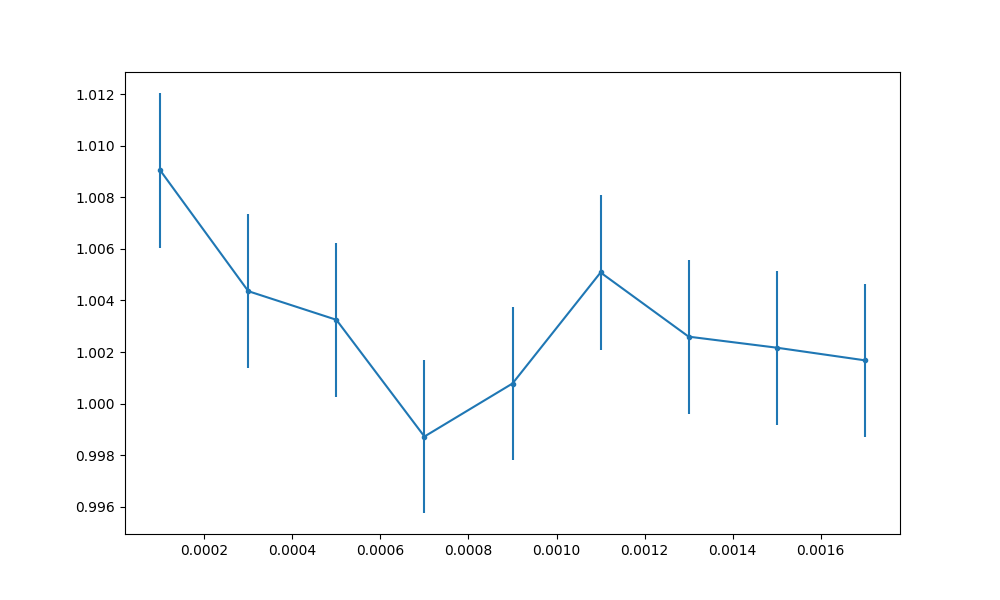

<ErrorbarContainer object of 3 artists>

In [81]:
plt.figure(figsize=(10,6))
back_counts = np.array([x[1][1] for x in t1_scan])
sig_counts = np.array([x[1][0] for x in t1_scan])
scan = np.array(t1_scan)
x_data = t1_scan[:, 0]
y_data = sig_counts/back_counts
y_err = (np.sqrt(sig_counts)/sig_counts)**2
y_err += (np.sqrt(back_counts)/back_counts)**2
y_err = np.sqrt(y_err) * y_data
plt.errorbar(x_data, y_data, yerr=y_err, fmt='.-')